In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
import cv2
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
final = pd.read_csv('mapping/final_dataset.csv')

In [3]:
final['banana'] = int(0)
final.loc[final['is_banana'] == True, 'banana'] = int(1)

In [4]:
final_small = final.sample(100)
final_small

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
2679,Carlos_Vera_Arteaga_RGB_15_11297_11053_15297_1...,932.759460,136.222687,1110.253296,322.891083,0.246115,Carlos_Vera_Arteaga_RGB,15,11297,11053,...,Carlos_Vera_Arteaga_RGB,9667.634357,9106.816780,7.957729,cacao,0.0,7.338873,2.862161,175,0
1888,Carlos_Vera_Guevara_RGB_2_0_7600_4000_11600.png,1621.685181,1269.766968,1779.147583,1408.365112,0.218883,Carlos_Vera_Guevara_RGB,2,0,7600,...,Carlos_Vera_Guevara_RGB,3155.730113,7720.838160,6.843647,cacao,0.0,5.444228,2.123249,46,0
785,Flora_Pluas_RGB_12_7600_7600_11600_11600.png,3444.513428,406.252350,3781.524902,735.447083,0.633447,Flora_Pluas_RGB,12,7600,7600,...,Flora_Pluas_RGB,10345.396328,6912.525899,11.522791,banana,0.0,5.473172,2.134537,7,1
56,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,2103.322754,566.057251,2312.849121,756.064209,0.208356,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,6593.775403,5522.885545,9.071811,banana,0.0,3.288588,1.282549,52,1
1104,Manuel_Macias_RGB_10_9748_3800_13748_7800.png,181.787781,402.727020,647.212952,912.274902,0.563320,Manuel_Macias_RGB,10,9748,3800,...,Manuel_Macias_RGB,10217.921426,4659.651631,2.387319,banana,0.0,0.191457,0.074668,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299,Nestor_Macias_RGB_6_3800_7600_7800_11600.png,2770.911865,3622.394287,2957.424072,3818.539062,0.265229,Nestor_Macias_RGB,6,3800,7600,...,Nestor_Macias_RGB,7775.868369,10006.406746,6.843647,cacao,0.0,5.444228,2.123249,215,0
99,Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png,2130.128662,3451.257080,2311.129639,3626.478516,0.344564,Carlos_Vera_Guevara_RGB,1,0,3800,...,Carlos_Vera_Guevara_RGB,4672.059902,7460.162024,14.642221,banana,0.0,9.117254,3.555729,178,1
4180,Nestor_Macias_RGB_1_0_3800_4000_7800.png,2827.364258,1307.073486,3072.075684,1560.815674,0.435718,Nestor_Macias_RGB,1,0,3800,...,Nestor_Macias_RGB,5303.884153,5606.854710,11.140820,fruit,0.0,45.067274,17.576237,149,0
3998,Manuel_Macias_RGB_0_0_0_4000_4000.png,3163.223633,271.789490,3954.831299,994.351929,0.414117,Manuel_Macias_RGB,0,0,0,...,Manuel_Macias_RGB,5450.009328,4275.293967,2.387319,cacao,0.0,0.676596,0.263872,327,0


In [83]:
#train, trees_test = train_test_split(final, shuffle = True, random_state = 900, test_size = 0.2)

In [5]:
trees_train, trees_valid = train_test_split(final_small, shuffle = True, random_state = 900, test_size = 0.2)

In [6]:
trees_train

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
1742,Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png,2506.139160,5.085842,2731.916992,128.716965,0.410146,Carlos_Vera_Guevara_RGB,1,0,3800,...,Carlos_Vera_Guevara_RGB,4730.364624,3935.630598,6.843647,cacao,0.0,5.444228,2.123249,407,0
4329,Nestor_Macias_RGB_5_3800_3800_7800_7800.png,3751.683838,2301.143311,3993.237793,2554.844238,0.297034,Nestor_Macias_RGB,5,3800,3800,...,Nestor_Macias_RGB,8553.509435,6187.362671,6.843647,cacao,0.0,5.444228,2.123249,123,0
2994,Flora_Pluas_RGB_10_7600_0_11600_4000.png,655.729675,2433.116699,953.982849,2736.620850,0.319534,Flora_Pluas_RGB,10,7600,0,...,Flora_Pluas_RGB,7573.699003,5430.564728,7.957729,cacao,0.0,7.338873,2.862161,281,0
1223,Nestor_Macias_RGB_4_3800_0_7800_4000.png,654.923218,3231.352539,988.320679,3550.252686,0.494629,Nestor_Macias_RGB,4,3800,0,...,Nestor_Macias_RGB,6154.865619,5365.969290,11.459129,banana,0.0,5.408965,2.109496,147,1
80,Carlos_Vera_Guevara_RGB_6_3800_7600_7800_11600...,665.722717,1660.371582,815.775696,1830.353638,0.228570,Carlos_Vera_Guevara_RGB,6,3800,7600,...,Carlos_Vera_Guevara_RGB,5462.887651,8151.261231,10.822511,banana,0.0,4.788946,1.867689,163,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,Nestor_Macias_RGB_1_0_3800_4000_7800.png,3132.033447,2556.746826,3319.499268,2749.653809,0.265628,Nestor_Macias_RGB,1,0,3800,...,Nestor_Macias_RGB,5081.111365,6451.663190,6.843647,cacao,0.0,5.444228,2.123249,445,0
1047,Manuel_Macias_RGB_8_7600_6879_11600_10879.png,205.267822,287.240082,417.789215,514.132019,0.356642,Manuel_Macias_RGB,8,7600,6879,...,Manuel_Macias_RGB,8838.922842,6941.140310,21.645022,banana,0.0,20.962055,8.175201,10,1
3245,Leonor_Aspiazu_RGB_1_0_3800_4000_7800.png,2295.483398,1207.905640,2502.064453,1399.640381,0.216778,Leonor_Aspiazu_RGB,1,0,3800,...,Leonor_Aspiazu_RGB,5401.173229,6884.053923,1.909855,cacao,70.0,0.434958,0.169634,401,0
2531,Carlos_Vera_Arteaga_RGB_1_0_3800_4000_7800.png,1334.437378,9.873938,1579.638306,170.528152,0.263436,Carlos_Vera_Arteaga_RGB,1,0,3800,...,Carlos_Vera_Arteaga_RGB,5159.830877,4397.388266,7.957729,fruit,0.0,18.538871,7.230160,397,0


In [7]:
# make the training set
trees_train.to_csv('mapping/train_small.csv', index = False) 

In [8]:
# make the validation set
trees_valid.to_csv('mapping/valid_small.csv', index = False) 

In [88]:
# make the test set
#trees_test.to_csv('mapping/test.csv', index = False) 

In [9]:
trees_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 1742 to 2076
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   img_path          80 non-null     object 
 1   xmin              80 non-null     float64
 2   ymin              80 non-null     float64
 3   xmax              80 non-null     float64
 4   ymax              80 non-null     float64
 5   score             80 non-null     float64
 6   img_name          80 non-null     object 
 7   tile_index        80 non-null     int64  
 8   tile_xmin         80 non-null     int64  
 9   tile_ymin         80 non-null     int64  
 10  tile_xmax         80 non-null     int64  
 11  tile_ymax         80 non-null     int64  
 12  x                 80 non-null     float64
 13  y                 80 non-null     float64
 14  Xmin              80 non-null     float64
 15  Ymin              80 non-null     float64
 16  Xmax              80 non-null     float64

In [10]:
trees_train['group'].value_counts()

cacao     34
banana    30
fruit     15
timber     1
Name: group, dtype: int64

In [11]:
trees_train['site'].value_counts()

Flora_Pluas_RGB            18
Carlos_Vera_Guevara_RGB    16
Nestor_Macias_RGB          16
Manuel_Macias_RGB          11
Carlos_Vera_Arteaga_RGB    10
Leonor_Aspiazu_RGB          9
Name: site, dtype: int64

In [12]:
trees_valid['group'].value_counts()

cacao     9
banana    5
fruit     5
timber    1
Name: group, dtype: int64

In [13]:
trees_valid['site'].value_counts()

Carlos_Vera_Arteaga_RGB    5
Nestor_Macias_RGB          5
Flora_Pluas_RGB            4
Carlos_Vera_Guevara_RGB    4
Leonor_Aspiazu_RGB         1
Manuel_Macias_RGB          1
Name: site, dtype: int64

<Axes: >

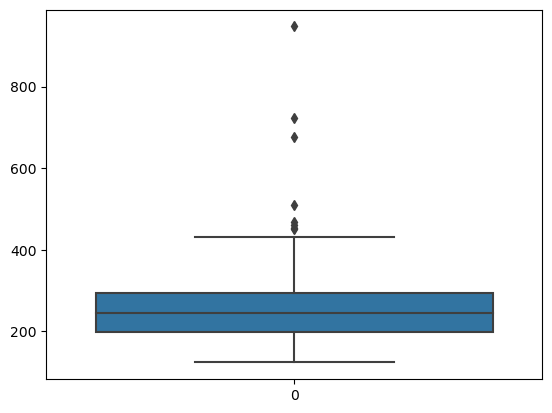

In [14]:
h = trees_train['ymax'].values - trees_train['ymin'].values

# Boxplot of bbox heights
sns.boxplot(h)

<Axes: >

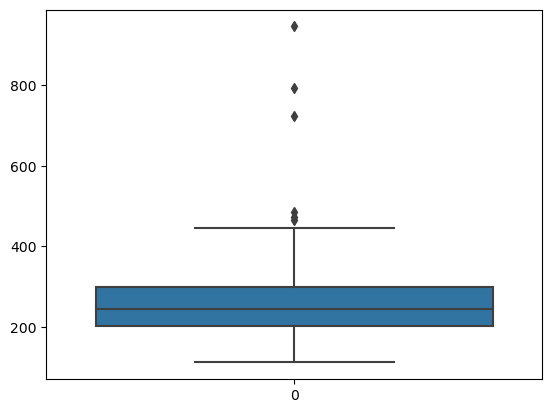

In [15]:
w = trees_train['xmax'].values - trees_train['xmin'].values

# Boxplot of bbox widths
sns.boxplot(w)

<Axes: >

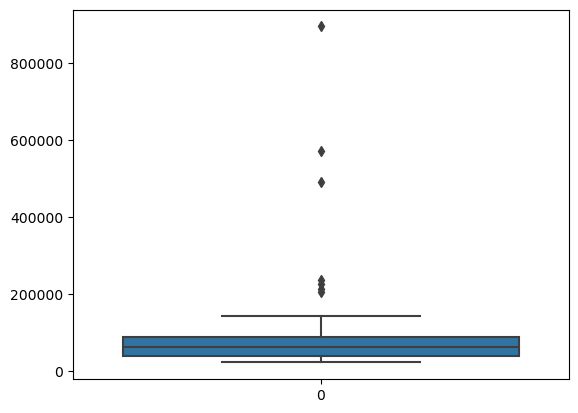

In [16]:
area = h * w

# Boxplot of bbox widths
sns.boxplot(area)
# Area can vary by 2 orders of magnitude, 
#we need to resize the images to be of similar sizes

In [17]:
trees_train.loc[trees_train['ymax'] - trees_train['ymin'] > 800]

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
3203,Leonor_Aspiazu_RGB_1_0_3800_4000_7800.png,2470.236572,2887.485107,3415.473877,3835.081543,0.423009,Leonor_Aspiazu_RGB,1,0,3800,...,Leonor_Aspiazu_RGB,5610.649465,7677.179313,5.411255,cacao,0.0,3.419771,1.333711,50,0


In [18]:
trees_train.loc[trees_train['group']=='banana']

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
1223,Nestor_Macias_RGB_4_3800_0_7800_4000.png,654.923218,3231.352539,988.320679,3550.252686,0.494629,Nestor_Macias_RGB,4,3800,0,...,Nestor_Macias_RGB,6154.865619,5365.969290,11.459129,banana,0.0,5.408965,2.109496,147,1
80,Carlos_Vera_Guevara_RGB_6_3800_7600_7800_11600...,665.722717,1660.371582,815.775696,1830.353638,0.228570,Carlos_Vera_Guevara_RGB,6,3800,7600,...,Carlos_Vera_Guevara_RGB,5462.887651,8151.261231,10.822511,banana,0.0,4.788946,1.867689,163,1
1104,Manuel_Macias_RGB_10_9748_3800_13748_7800.png,181.787781,402.727020,647.212952,912.274902,0.563320,Manuel_Macias_RGB,10,9748,3800,...,Manuel_Macias_RGB,10217.921426,4659.651631,2.387319,banana,0.0,0.191457,0.074668,88,1
1184,Nestor_Macias_RGB_1_0_3800_4000_7800.png,1994.039551,2948.834717,2272.371338,3211.500000,0.351622,Nestor_Macias_RGB,1,0,3800,...,Nestor_Macias_RGB,4673.876359,6720.107975,6.843647,banana,0.0,1.804196,0.703637,82,1
56,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,2103.322754,566.057251,2312.849121,756.064209,0.208356,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,6593.775403,5522.885545,9.071811,banana,0.0,3.288588,1.282549,52,1
872,Leonor_Aspiazu_RGB_9_7600_3800_11600_7800.png,1764.918335,607.161133,2000.293579,859.122559,0.515997,Leonor_Aspiazu_RGB,9,7600,3800,...,Leonor_Aspiazu_RGB,9594.492803,4057.308936,10.981665,banana,0.0,4.940200,1.926678,202,1
26,Carlos_Vera_Guevara_RGB_0_0_0_4000_4000.png,2262.220947,3339.274902,2516.451172,3580.773682,0.408996,Carlos_Vera_Guevara_RGB,0,0,0,...,Carlos_Vera_Guevara_RGB,4501.521133,4977.682988,17.825312,banana,0.0,13.862143,5.406236,150,1
785,Flora_Pluas_RGB_12_7600_7600_11600_11600.png,3444.513428,406.252350,3781.524902,735.447083,0.633447,Flora_Pluas_RGB,12,7600,7600,...,Flora_Pluas_RGB,10345.396328,6912.525899,11.522791,banana,0.0,5.473172,2.134537,7,1
1045,Manuel_Macias_RGB_8_7600_6879_11600_10879.png,389.998047,1161.418579,636.230469,1449.107056,0.383684,Manuel_Macias_RGB,8,7600,6879,...,Manuel_Macias_RGB,9119.941039,7699.908055,2.387319,banana,0.0,0.191457,0.074668,25,1
1302,Nestor_Macias_RGB_6_3800_7600_7800_11600.png,2431.410400,1523.587646,2758.606201,1860.844360,0.602723,Nestor_Macias_RGB,6,3800,7600,...,Nestor_Macias_RGB,7089.241363,7929.197374,13.846448,banana,0.0,8.094164,3.156724,300,1


In [19]:
n = 0
img_name = trees_train.iloc[n, 0]
print(img_name)

Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png


In [20]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

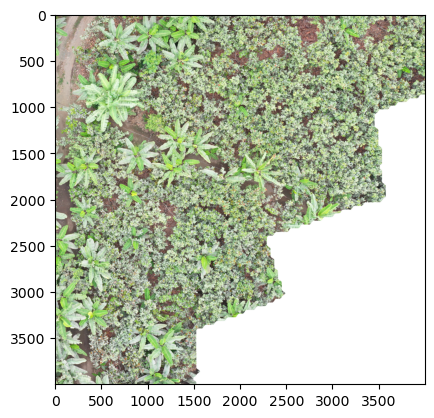

In [186]:
plt.imshow(tile1)
plt.show()

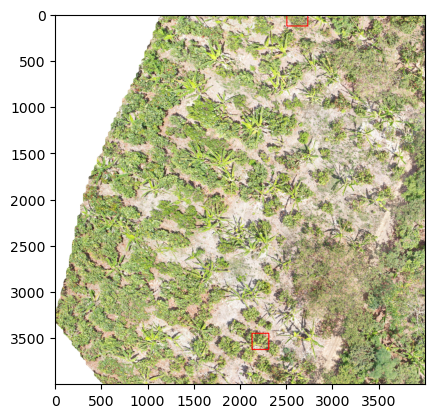

In [21]:
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [22]:
def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

In [23]:
preprocess = transforms.Compose([
                     
                     #transforms.RandomResizedCrop(224),
                     transforms.ToTensor(),
                     transforms.Resize(224)
                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

In [28]:
class Trees(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        xmin = self.trees_frame.iloc[idx]['xmin']
        ymin = self.trees_frame.iloc[idx]['ymin']
        xmax = self.trees_frame.iloc[idx]['xmax']
        ymax = self.trees_frame.iloc[idx]['ymax']
        
        image = image[round(ymin):round(ymax)+1, round(xmin):round(xmax)+1]
        image = center_crop(image, [800, 800])
        
        border_height = round((800 - image.shape[0]) / 2)
        border_width  = round((800 - image.shape[1]) / 2)
        
        image = cv2.copyMakeBorder(image, border_height, border_height, border_width, border_width, cv2.BORDER_CONSTANT, None, value = 0)
        
        DBH = self.trees_frame.iloc[idx]['updated diameter']
        
        #image = Image.fromarray(image)
        
        #image = transforms.Resize(224)
        image = preprocess(image)

        
        sample = image, float(DBH)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [29]:
ttrain = Trees(csv_file='mapping/train_small.csv', root_dir='tiles/all_tiles')

In [191]:
imgs = torch.stack([img_t for img_t, _ in ttrain], dim=3)

In [192]:
imgs.view(3, -1).mean(dim=1)

tensor([0.0893, 0.0985, 0.0722])

In [193]:
imgs.view(3, -1).std(dim=1)

tensor([0.2281, 0.2495, 0.1898])

In [30]:
tvalid = Trees(csv_file='mapping/valid_small.csv', root_dir='tiles/all_tiles')

(array([9.56692428e+00, 8.30410277e-03, 2.67724253e-02, 4.73001729e-02,
        5.63350374e-02, 6.84257915e-02, 7.92543863e-02, 7.16809991e-02,
        4.82302468e-02, 2.67724213e-02]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

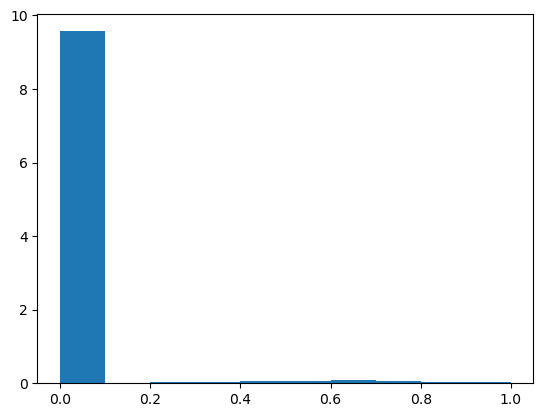

In [31]:
plt.hist(ttrain[0][0].ravel(), density=True)

(array([9.14229855, 0.02214349, 0.03856601, 0.06831502, 0.1337359 ,
        0.18542642, 0.20979104, 0.22204063, 0.09591025, 0.01312456]),
 array([0.        , 0.09870351, 0.19740702, 0.29611054, 0.39481404,
        0.49351755, 0.59222108, 0.69092458, 0.78962809, 0.88833159,
        0.9870351 ]),
 <BarContainer object of 10 artists>)

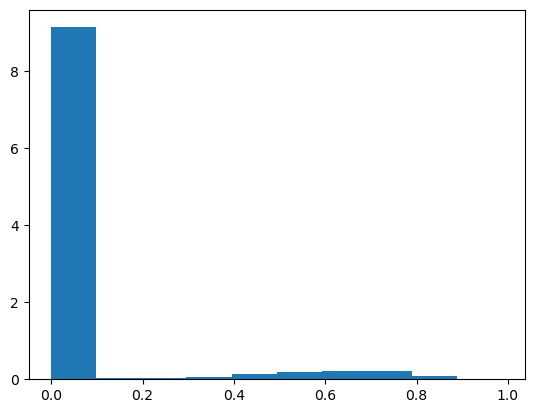

In [32]:
plt.hist(tvalid[0][0].ravel(), density=True)

is_banana: 6.843646549530001


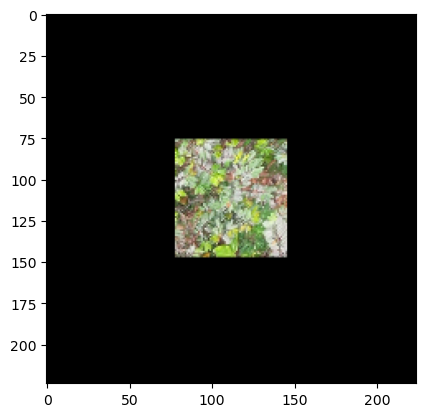

In [33]:
im, label = ttrain[1]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

is_banana: 11.4591291062


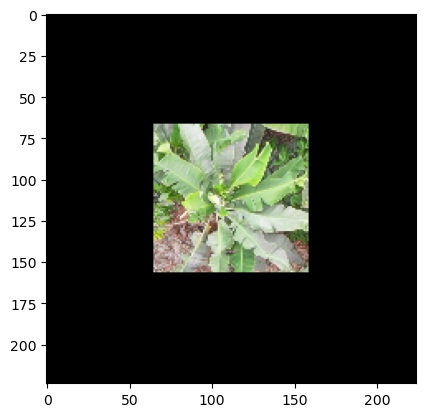

In [34]:
im, label = ttrain[3]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

In [35]:
for i in range(len(ttrain)):
    sample = ttrain[i]

    print(i, sample[0].shape, sample[1])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 6.843646549530001
1 torch.Size([3, 224, 224]) 6.843646549530001
2 torch.Size([3, 224, 224]) 7.957728545960001
3 torch.Size([3, 224, 224]) 11.4591291062


In [ ]:
# Wrap it onto a dataloader

In [47]:
train_dataloader = DataLoader(ttrain, batch_size=16, shuffle=True)

In [48]:
valid_dataloader = DataLoader(tvalid, batch_size=16, shuffle=False)

In [49]:
print(len(train_dataloader), len(valid_dataloader))

5 2


In [50]:
print('Train dataset size:', len(ttrain))

Train dataset size: 80


In [51]:
model = models.resnet18(pretrained=True)

In [38]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Below, we train resnet18 for with our images

In [66]:
#def set_parameter_requires_grad(model, feature_extracting=True):
#    if feature_extracting:
#        for param in model.parameters():
#            param.requires_grad = False
            
#set_parameter_requires_grad(resnet18, False)

In [52]:
modelOutputFeats = model.fc.in_features
modelOutputFeats

512

In [53]:
# Initialize new final output layer
model.fc = nn.Linear(modelOutputFeats, 1)

#fc = nn.Sequential(OrderedDict([
#    ('fc1', nn.Linear(512,100)),
#    ('relu', nn.ReLU()),
#    ('fc2', nn.Linear(100,2)),
#    ('output', nn.LogSoftmax(dim=1))
#]))

#model.fc = fc

In [54]:
# Check which layer in the model that will compute the gradient
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [55]:
# Here we only want to update the gradient for the classifier layer that we initialized.
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
#optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [56]:
optimizer = torch.optim.Adam(model.fc.parameters())

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = nn.MSELoss()

In [58]:
device

device(type='cuda')

In [ ]:
train_loss = []
val_loss = []

epochs = 20

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
#       model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          label = label.unsqueeze(1)
          optimizer.zero_grad()
          y_pred = model(image)
          #print(y_pred)
          loss = criterion(y_pred,label.float())         
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          #val, index_ = torch.max(y_pred,axis=1)
          #print(label.data, y_pred)
          #running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()
      
      #epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
     # print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      print("Training loss: {}".format(epoch_loss))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()

                #val, index_ = torch.max(y_pred,axis=1)
                #running_score += torch.sum(index_ == label.data).item()
          
          #epoch_score = running_score/len(valid_dataloader.dataset)
          epoch_loss = running_loss/len(valid_dataloader.dataset)
          val_loss.append(epoch_loss)
          #print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
          print("Validation loss: {}".format(epoch_loss))


epoch 1/20


In [216]:
epochs = range(1, 21)

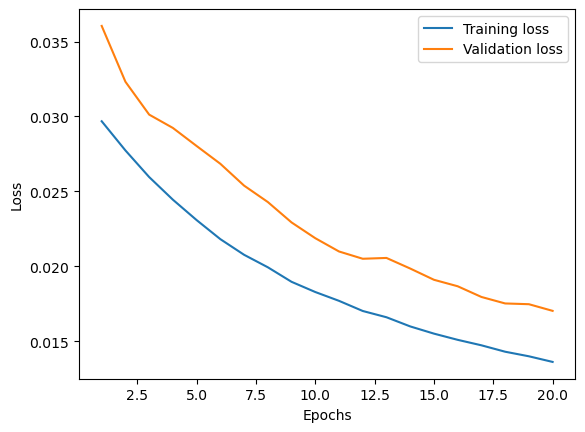

In [220]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()